<a href="https://colab.research.google.com/github/precal171/skills-code-with-codespaces/blob/main/Volcano_Plot_Code_for_mass_spec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/matplotlib/transforms.py:354: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]


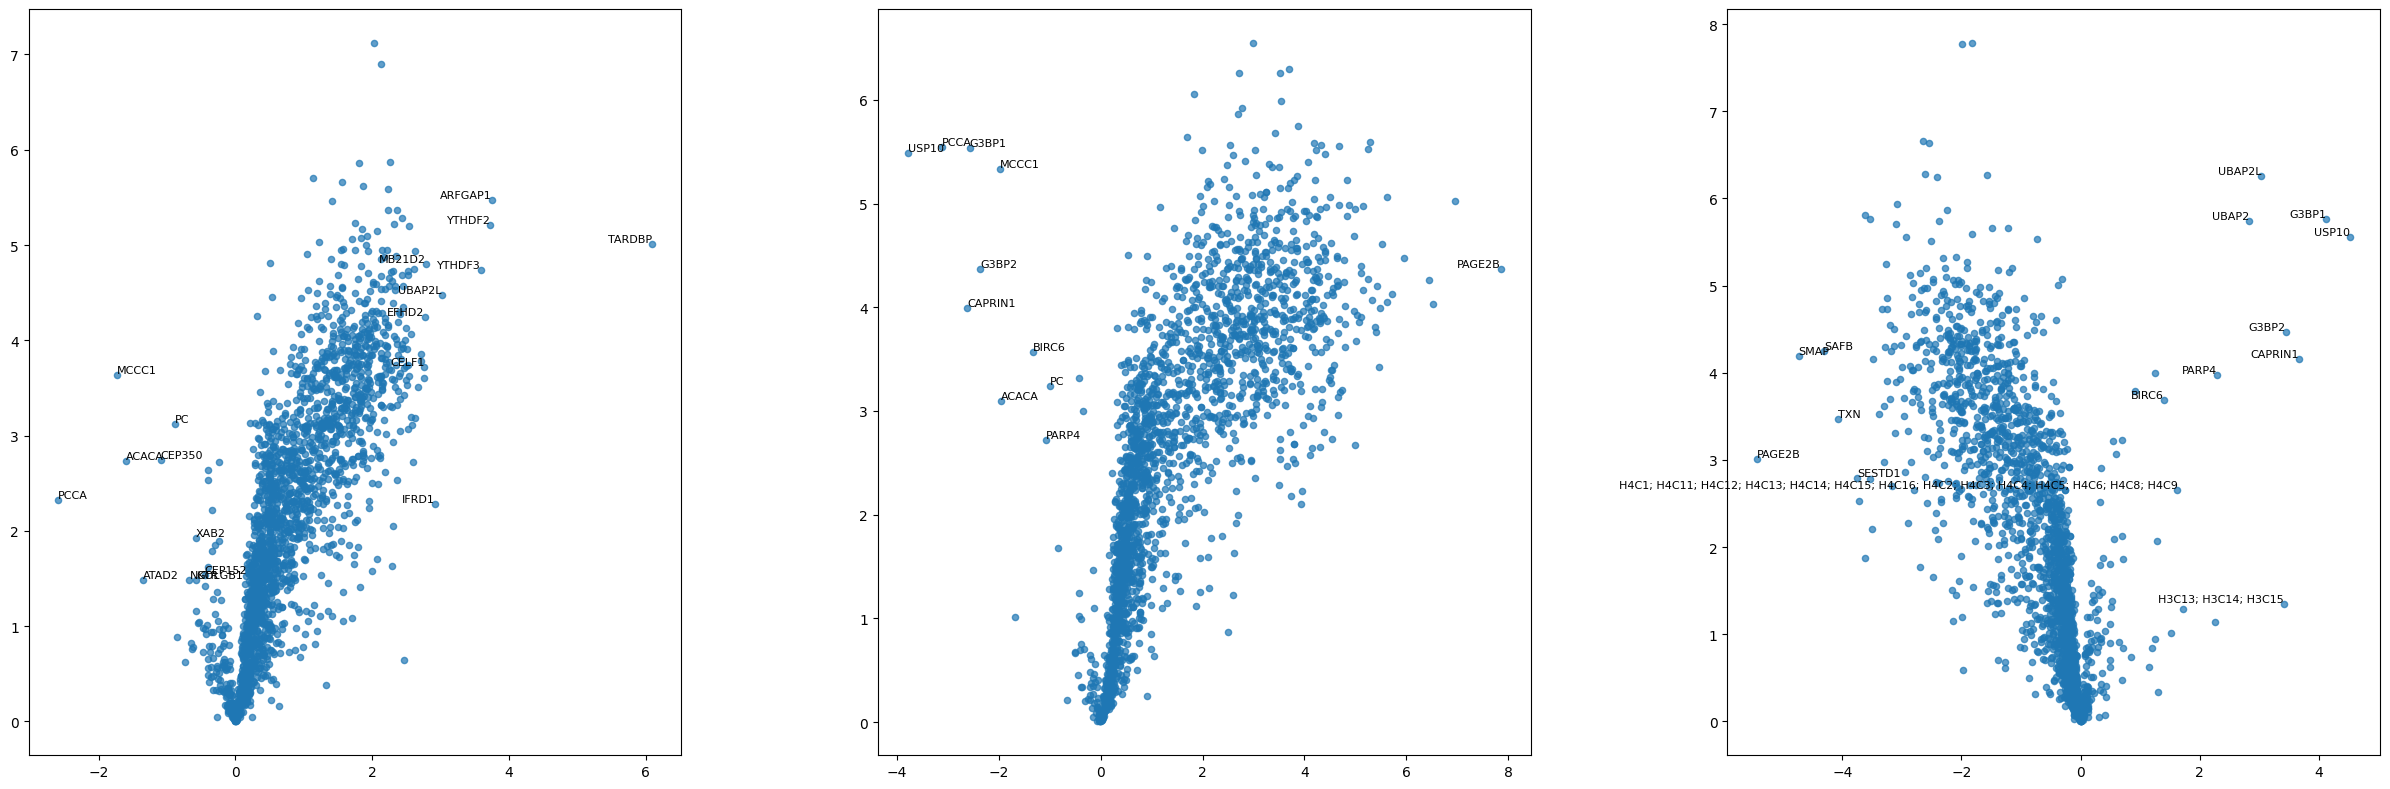

In [35]:
!pip install pandas openpyxl xlrd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Read data from Excel file in Google Drive
df = pd.read_excel('/content/drive/MyDrive/tdp_volcano.xlsx')  # Update with your file path and sheet name

# Calculate means and standard deviations for all groups
df['Control_Mean'] = df[['Abundance S1', 'Abundance S2', 'Abundance S3']].mean(axis=1)
df['Control_Std'] = df[['Abundance S1', 'Abundance S2', 'Abundance S3']].std(axis=1)
df['TDP_Mean'] = df[['Abundance T1', 'Abundance T2', 'Abundance T3']].mean(axis=1)
df['TDP_Std'] = df[['Abundance T1', 'Abundance T2', 'Abundance T3']].std(axis=1)
df['NTF_Mean'] = df[['Abundance N1', 'Abundance N2', 'Abundance N3']].mean(axis=1)
df['NTF_Std'] = df[['Abundance N1', 'Abundance N2', 'Abundance N3']].std(axis=1)

# Calculate log2 fold changes and p-values
df['log2FC_Control'] = np.log2(df['TDP_Mean'] / df['Control_Mean'])
df['log2FC_NTF'] = np.log2(df['TDP_Mean'] / df['NTF_Mean'])
df['log2FC_NTF_Control'] = np.log2(df['NTF_Mean'] / df['Control_Mean'])  # NTF vs. Control

p_values_control = []
p_values_ntf = []
p_values_ntf_control = []  # For NTF vs. Control
for i in range(len(df)):
    control_vals = [df['Abundance S1'][i], df['Abundance S2'][i], df['Abundance S3'][i]]
    ntf_vals = [df['Abundance N1'][i], df['Abundance N2'][i], df['Abundance N3'][i]]
    tdp_vals = [df['Abundance T1'][i], df['Abundance T2'][i], df['Abundance T3'][i]]

    t_stat_control, p_val_control = stats.ttest_ind(control_vals, tdp_vals)
    t_stat_ntf, p_val_ntf = stats.ttest_ind(ntf_vals, tdp_vals)
    t_stat_ntf_control, p_val_ntf_control = stats.ttest_ind(control_vals, ntf_vals)  # NTF vs. Control

    p_values_control.append(p_val_control)
    p_values_ntf.append(p_val_ntf)
    p_values_ntf_control.append(p_val_ntf_control)  # For NTF vs. Control

df['p_value_Control'] = p_values_control
df['p_value_NTF'] = p_values_ntf
df['p_value_NTF_Control'] = p_values_ntf_control  # For NTF vs. Control

# Adjust p-values (replace with your preferred method if needed)
df['adj_p_value_Control'] = p_values_control
df['adj_p_value_NTF'] = p_values_ntf
df['adj_p_value_NTF_Control'] = p_values_ntf_control  # For NTF vs. Control



# Create volcano plots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # Create three subplots

# Function to label top genes
def label_top_genes(df, x_col, y_col, gene_col, top_n=10, ax=None):
    # Filter by adjusted p-value first, then select top N enriched
    top_enriched = df[df[y_col] < 0.05].sort_values(by=[x_col], ascending=False).head(top_n)

    # Filter by adjusted p-value first, then select top N de-enriched
    top_de_enriched = df[df[y_col] < 0.05].sort_values(by=[x_col], ascending=True).head(top_n)

    # Add labels for top enriched genes
    for i in top_enriched.index:
        ax.text(top_enriched[x_col][i], -np.log10(top_enriched[y_col][i]),
                 top_enriched[gene_col][i], fontsize=8, ha='right', va='bottom')

    # Add labels for top de-enriched genes
    for i in top_de_enriched.index:
        ax.text(top_de_enriched[x_col][i], -np.log10(top_de_enriched[y_col][i]),
                 top_de_enriched[gene_col][i], fontsize=8, ha='left', va='bottom')

# Volcano plot for TDP vs. Control
axes[0].scatter(df['log2FC_Control'], -np.log10(df['adj_p_value_Control']), s=20, alpha=0.7)
# ... (rest of the code for TDP vs. Control plot) ...
label_top_genes(df, 'log2FC_Control', 'adj_p_value_Control', 'Gene Symbol', ax=axes[0])

# Volcano plot for TDP vs. NTF
axes[1].scatter(df['log2FC_NTF'], -np.log10(df['adj_p_value_NTF']), s=20, alpha=0.7)
# ... (rest of the code for TDP vs. NTF plot) ...
label_top_genes(df, 'log2FC_NTF', 'adj_p_value_NTF', 'Gene Symbol', ax=axes[1])

# Volcano plot for NTF vs. Control
axes[2].scatter(df['log2FC_NTF_Control'], -np.log10(df['adj_p_value_NTF_Control']), s=20, alpha=0.7)
# ... (rest of the code for NTF vs. Control plot) ...
label_top_genes(df, 'log2FC_NTF_Control', 'adj_p_value_NTF_Control', 'Gene Symbol', ax=axes[2])

plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()